## Import and Configure Everything We Need

In [2]:
from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

__author__ = 'Marcel Baltruschat'
__copyright__ = 'Copyright © 2020-2023'
__license__ = 'MIT'
__version__ = '1.1.0'

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation
sns.set(palette='bright')  # Set bright style for Seaborn
PandasTools.RenderImagesInAllDataFrames()  # Render mol images

# In many cases NaN
not_used_desc = [
    'HeavyAtomMolWt',
    "ExactMolWt",
    "FpDensityMorgan1",
    "FpDensityMorgan2",
    "FpDensityMorgan3",
    'MaxPartialCharge', 
    'MinPartialCharge',
    'MaxAbsPartialCharge', 
    'MinAbsPartialCharge', 
    'BCUT2D_MWHI',
    'BCUT2D_MWLOW',
    'BCUT2D_CHGHI',
    'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI',
    'BCUT2D_LOGPLOW',
    'BCUT2D_MRHI',
    'BCUT2D_MRLOW',
]

# Create a descriptor calculator for all RDKit descriptors except the ones above
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])
print(f'Number of descriptors used: {len(desc_calc.descriptorNames)}/{len(Descriptors.descList)}')

Number of descriptors used: 191/208


## Defining Cross-Validation Class

In [3]:
"""
Copyright © 2019 Marcel Baltruschat

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files 
(the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, 
publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do 
so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

Source: https://github.com/czodrowskilab/gafp/tree/master/fp
"""
class CVRegressor:
    """
    Regressor that predicts based on predictions of k models from k-fold CV.
    Accepts any Scikit-learn-like regressor as base regressor. It trains k models
    by doing k-fold CV and stores the individual models. Predictions
    on new samples are done by calculating mean predictions from all models.
    
    Parameters
    ----------
    est : Any
        Scikit-learn (-like) regressor object. Must contain .fit() and .predict() methods.
    params : Dict[str, Any]
        Regressor parameters
    n_folds : int
        Number of folds for k-fold
    shuffle : bool
        Shuffling of data for CV
    """
    __slots__ = ('est', 'params', 'models', 'n_folds', 'shuffle', 'cv_scores')

    def __init__(self, est: Any, params: Dict[str, Any], n_folds: int = 5, shuffle: bool = True):
        self.est = est
        self.params = params
        self.models = []
        self.n_folds = n_folds
        self.shuffle = shuffle
        self.cv_scores = ddict(list)

    def fit(self, x_data: np.ndarray, y_data: np.ndarray, scoring_funcs: List=(), random_state: int=None) -> None:
        """
        Build a regressor consisting of k-models.
        
        Parameters
        ----------
        x_data : numpy.ndarray
            Training data
        y_data : numpy.ndarray
            Target values
        scoring_funcs : list
            List of scoring functions to use for evaluating cross-validation results
        random_state : int
            Integer to use for seeding the k-fold split
        """

        kf = KFold(n_splits=self.n_folds, shuffle=self.shuffle, random_state=random_state)
        kf = kf.split(X=x_data, y=y_data)

        # Fit k models and store them
        for train_index, test_index in kf:
            est_tmp = self.est(**self.params)
            est_tmp.fit(x_data[train_index], y_data[train_index])
            if scoring_funcs:
                test_pred = est_tmp.predict(x_data[test_index])
                for sf in scoring_funcs:
                    self.cv_scores[str(sf).split(' ')[1]].append(sf(y_data[test_index], test_pred))
            self.models.append(est_tmp)

    def predict(self, x_data: np.ndarray) -> np.ndarray:
        """
        Predict using prediction mean from k models.
        
        Parameters
        ----------
        x_data : numpy.ndarray
            Samples to predict
        
        Returns
        -------
        numpy.ndarray
            Predicted values
        """

        return np.mean([m.predict(x_data) for m in self.models], axis=0)

## Defining Helpful Functions

In [4]:
def rmse(y_true, y_pred):
    """Helper function"""
    return mean_squared_error(y_true, y_pred, squared=False)

def calc_stats_str(pka1, pka2):
    """Calculates R², MAE and RMSE for two iterables of floats or integers"""
    assert len(pka1) == len(pka2), "Both iterables must have the same length"
    return f'R²: {r2_score(pka1, pka2):.3f}\n' \
           f'MAE: {mean_absolute_error(pka1, pka2):.3f}\n' \
           f'RMSE: {rmse(pka1, pka2):.3f}'

def train_cv_model(est_cls, x_data, y_data, params, random_state,
                   cv=5, shuffle=True, scaled=False, scoring_funcs=(mean_absolute_error, rmse, r2_score)):
    """Scales the training data if wanted and trains a cross-validated model"""
    scaler = None
    if scaled:
        scaler = StandardScaler()
        x_data = scaler.fit_transform(x_data)
    cvr = CVRegressor(est=est_cls, params=params, n_folds=cv, shuffle=shuffle)
    cvr.fit(x_data, y_data, scoring_funcs=scoring_funcs, random_state=random_state)
    return cvr, scaler

def calc_x_data(mols):
    """Calculates descriptors and fingerprints for an iterable of RDKit molecules"""
    descs = []  # 196/200 RDKit descriptors
    fmorgan3 = []  # 4096 bit
    for mol in mols:
        descs.append(desc_calc.CalcDescriptors(mol))
        fmorgan3.append(Chem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=4096, useFeatures=True))
    descs = np.array(descs)
    fmorgan3 = np.array(fmorgan3)
    return descs, fmorgan3, np.concatenate([descs, fmorgan3], axis=1)

---
## Loading Precombined Dataset

Initial: 5921


pKa  marvin_pKa  marvin_atom marvin_pKa_type original_dataset  \
ID                                                                       
273537 7.460       8.200            8           basic     ['chembl25']   
7175   4.200       3.940            7           basic  ['datawarrior']   

                                                   ROMol  
ID                                                        
273537  <rdkit.Chem.rdchem.Mol object at 0x7f30b6499d90>  
7175    <rdkit.Chem.rdchem.Mol object at 0x7f30b649a420>
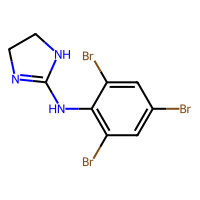
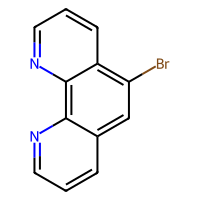

In [5]:
sdf_path = './datasets/combined_training_datasets_unique_no_oe.sdf'
all_df = PandasTools.LoadSDF(sdf_path).astype(dict(pKa=float, 
                                                   marvin_atom=int, 
                                                   marvin_pKa=float), 
                                              copy=False).set_index('ID', verify_integrity=True)
print(f'Initial: {len(all_df)}')
all_df.head(2)

## Show p<i>K</i><sub>a</sub> Distribution

In [6]:
sns_major, sns_minor = map(int, sns.__version__.split('.')[:2])

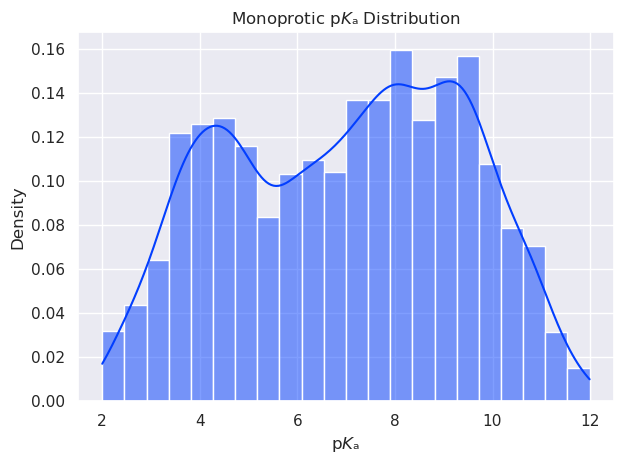

In [7]:
plt.figure(dpi=100)
if sns_major > 0 or sns_minor >= 11:
    sns.histplot(all_df.pKa, kde=True, stat='density')
else:
    sns.distplot(all_df.pKa)
plt.ylabel('Density')
plt.xlabel('p$K$ₐ')
plt.title('Monoprotic p$K$ₐ Distribution')
plt.tight_layout()
plt.show()

## Calculating Descriptors and Fingerprints
- Selected RDKit descriptors (see first notebook cell)
- Morgan FP with radius=3 and useFeatures=True (FMorgan3)

In [8]:
descs, fmorgan3, descs_fmorgan3 = calc_x_data(all_df.ROMol)

Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
             ^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/GraphDescriptors.py", line 124, in Ipc
    cPoly = abs(Graphs.CharacteristicPolynomial(mol, adjMat))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/Graphs.py", line 43, in CharacteristicPolynomial
    res = numpy.zeros(nAtoms + 1, numpy.float)
                                  ^^^^^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/__init__.py", line 324, in __getattr__
    raise AttributeError(__former_attrs__[attr])
AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code,

---
## Training Random Forest, Support Vector Machine (two configurations) and Multilayer Perceptron (three configurations)
#### Using the following training sets with 5-fold cross-validation (shuffled)
1. RDKit descriptor set
2. FMorgan3
3. RDKit descriptor set + FMorgan3
4. RDKit descriptor set (standard scaled)
5. FMorgan3 (standard scaled)
6. RDKit descriptor set + FMorgan3 (standard scaled)

### Prepare for Training

In [9]:
seed = 24

est_jobs = 48
verbose = False

y_train = all_df.pKa.values
desc_sets = list(zip([descs, fmorgan3, descs_fmorgan3] * 2, 
                     [False] * 3 + [True] * 3, 
                     ['Desc', 'FMorgan3', 'Desc_FMorgan3', 'Desc_scaled', 'FMorgan3_scaled', 'Desc_FMorgan3_scaled']))

models = ddict(odict)  # estimator => training set => [model, scaler]

def train_all_sets(est_cls, params, name):
    for x_data, scaled, set_name in desc_sets:
        models[name][set_name] = train_cv_model(est_cls, x_data, y_train, params, seed, scaled=scaled)

In [12]:
print(desc_sets[:5])


[(array([[4.27667269, 0.81826153, 4.27667269, ..., 0.        , 0.        ,
        0.        ],
       [4.37768519, 0.94673611, 4.37768519, ..., 0.        , 0.        ,
        0.        ],
       [3.85362056, 0.61342593, 3.85362056, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.27126039, 1.11171296, 4.27126039, ..., 0.        , 0.        ,
        0.        ],
       [3.82523148, 0.60185185, 3.82523148, ..., 0.        , 0.        ,
        0.        ],
       [3.375     , 1.33333333, 3.375     , ..., 0.        , 0.        ,
        0.        ]]), False, 'Desc'), (array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), False, 'FMorgan3'), (array([[4.27667269, 0.81826153, 4.27667269, ..., 0.        , 0.        ,
        0.        ],
       [4.37768519, 0.94673611, 4.37768519, ..., 0.        , 0.        ,
        0

In [10]:
def generate_score_board(name):
    print(f'{name} CV Scores:')
    for ts, (m, s) in models[name].items():
        print(f'\t{ts}')
        for k, v in m.cv_scores.items():
            print(f'\t\t- {k}: {np.mean(v):.3f} ± {np.std(v):.3f}')

---
### RandomForest (n_estimators=1000)

In [11]:
est_cls = RandomForestRegressor
rf_params = dict(n_estimators=1000, n_jobs=est_jobs, verbose=verbose, random_state=seed)
name = 'RandomForest (n_estimators=1000)'

train_all_sets(est_cls, rf_params, name)

#### CV Scores

In [13]:
generate_score_board(name)

RandomForest (n_estimators=1000) CV Scores:
	Desc
		- mean_absolute_error: 0.759 ± 0.023
		- rmse: 1.143 ± 0.042
		- r2_score: 0.773 ± 0.019
	FMorgan3
		- mean_absolute_error: 0.782 ± 0.029
		- rmse: 1.218 ± 0.052
		- r2_score: 0.742 ± 0.025
	Desc_FMorgan3
		- mean_absolute_error: 0.732 ± 0.022
		- rmse: 1.119 ± 0.047
		- r2_score: 0.782 ± 0.021
	Desc_scaled
		- mean_absolute_error: 0.759 ± 0.023
		- rmse: 1.144 ± 0.042
		- r2_score: 0.773 ± 0.019
	FMorgan3_scaled
		- mean_absolute_error: 0.782 ± 0.029
		- rmse: 1.218 ± 0.052
		- r2_score: 0.742 ± 0.025
	Desc_FMorgan3_scaled
		- mean_absolute_error: 0.732 ± 0.022
		- rmse: 1.119 ± 0.047
		- r2_score: 0.782 ± 0.021


---
### SupportVectorMachine (gamma='scale')

In [14]:
est_cls = SVR
svr_params = dict(cache_size=4096, verbose=verbose)
name = 'SupportVectorMachine (gamma="scale")'

train_all_sets(est_cls, svr_params, name)

#### CV Scores

In [15]:
generate_score_board(name)

SupportVectorMachine (gamma="scale") CV Scores:
	Desc
		- mean_absolute_error: 1.832 ± 0.026
		- rmse: 2.192 ± 0.022
		- r2_score: 0.166 ± 0.009
	FMorgan3
		- mean_absolute_error: 0.885 ± 0.012
		- rmse: 1.301 ± 0.029
		- r2_score: 0.706 ± 0.018
	Desc_FMorgan3
		- mean_absolute_error: 1.831 ± 0.026
		- rmse: 2.191 ± 0.022
		- r2_score: 0.167 ± 0.009
	Desc_scaled
		- mean_absolute_error: 0.894 ± 0.011
		- rmse: 1.319 ± 0.016
		- r2_score: 0.698 ± 0.010
	FMorgan3_scaled
		- mean_absolute_error: 1.110 ± 0.011
		- rmse: 1.501 ± 0.012
		- r2_score: 0.609 ± 0.009
	Desc_FMorgan3_scaled
		- mean_absolute_error: 1.046 ± 0.013
		- rmse: 1.436 ± 0.009
		- r2_score: 0.642 ± 0.009


---
### SupportVectorMachine (gamma='auto')

In [17]:
est_cls = SVR
svr_params = dict(cache_size=4096, verbose=verbose, gamma='auto')
name = 'SupportVectorMachine (gamma="auto")'

train_all_sets(est_cls, svr_params, name)

#### CV Scores

In [18]:
generate_score_board(name)

SupportVectorMachine (gamma="auto") CV Scores:
	Desc
		- mean_absolute_error: 1.932 ± 0.025
		- rmse: 2.296 ± 0.023
		- r2_score: 0.086 ± 0.006
	FMorgan3
		- mean_absolute_error: 1.652 ± 0.020
		- rmse: 1.983 ± 0.016
		- r2_score: 0.318 ± 0.007
	Desc_FMorgan3
		- mean_absolute_error: 1.254 ± 0.031
		- rmse: 1.705 ± 0.037
		- r2_score: 0.496 ± 0.018
	Desc_scaled
		- mean_absolute_error: 0.902 ± 0.012
		- rmse: 1.328 ± 0.016
		- r2_score: 0.694 ± 0.011
	FMorgan3_scaled
		- mean_absolute_error: 1.110 ± 0.011
		- rmse: 1.501 ± 0.012
		- r2_score: 0.609 ± 0.009
	Desc_FMorgan3_scaled
		- mean_absolute_error: 1.045 ± 0.013
		- rmse: 1.435 ± 0.009
		- r2_score: 0.642 ± 0.009


---
### Multi Layer Perceptron (early_stopping=False, hidden_layer_sizes=(500, 500))

In [19]:
est_cls = MLPRegressor
mlp_params = dict(hidden_layer_sizes=(500, 500), verbose=verbose, random_state=seed)
name = 'Multi Layer Perceptron (early_stopping=False, hidden_layer_sizes=(500, 500))'

train_all_sets(est_cls, mlp_params, name)

#### CV Scores

In [20]:
generate_score_board(name)

Multi Layer Perceptron (early_stopping=False, hidden_layer_sizes=(500, 500)) CV Scores:
	Desc
		- mean_absolute_error: 1.731 ± 0.844
		- rmse: 2.311 ± 0.912
		- r2_score: -0.062 ± 0.888
	FMorgan3
		- mean_absolute_error: 0.899 ± 0.017
		- rmse: 1.319 ± 0.027
		- r2_score: 0.698 ± 0.015
	Desc_FMorgan3
		- mean_absolute_error: 0.878 ± 0.025
		- rmse: 1.283 ± 0.055
		- r2_score: 0.713 ± 0.029
	Desc_scaled
		- mean_absolute_error: 0.753 ± 0.015
		- rmse: 1.138 ± 0.022
		- r2_score: 0.775 ± 0.011
	FMorgan3_scaled
		- mean_absolute_error: 1.085 ± 0.016
		- rmse: 1.518 ± 0.017
		- r2_score: 0.600 ± 0.014
	Desc_FMorgan3_scaled
		- mean_absolute_error: 1.024 ± 0.002
		- rmse: 1.458 ± 0.010
		- r2_score: 0.631 ± 0.008


---
### Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(500, 500))

In [21]:
est_cls = MLPRegressor
mlp_params = dict(hidden_layer_sizes=(500, 500), verbose=verbose, random_state=seed, early_stopping=True)
name = 'Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(500, 500))'

train_all_sets(est_cls, mlp_params, name)

#### CV Scores

In [22]:
generate_score_board(name)

Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(500, 500)) CV Scores:
	Desc
		- mean_absolute_error: 1.188 ± 0.097
		- rmse: 1.602 ± 0.072
		- r2_score: 0.554 ± 0.038
	FMorgan3
		- mean_absolute_error: 0.918 ± 0.023
		- rmse: 1.339 ± 0.033
		- r2_score: 0.689 ± 0.020
	Desc_FMorgan3
		- mean_absolute_error: 0.932 ± 0.077
		- rmse: 1.384 ± 0.174
		- r2_score: 0.661 ± 0.098
	Desc_scaled
		- mean_absolute_error: 0.782 ± 0.027
		- rmse: 1.154 ± 0.033
		- r2_score: 0.769 ± 0.015
	FMorgan3_scaled
		- mean_absolute_error: 1.054 ± 0.015
		- rmse: 1.483 ± 0.018
		- r2_score: 0.618 ± 0.013
	Desc_FMorgan3_scaled
		- mean_absolute_error: 1.005 ± 0.031
		- rmse: 1.434 ± 0.038
		- r2_score: 0.643 ± 0.022


---
### Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(250, 250, 250))

In [29]:
est_cls = MLPRegressor
mlp_params = dict(hidden_layer_sizes=(250, 250, 250), verbose=verbose, random_state=seed, early_stopping=True)
name = 'Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(250, 250, 250))'

train_all_sets(est_cls, mlp_params, name)

#### CV Scores

In [30]:
generate_score_board(name)

Multi Layer Perceptron (early_stopping=True, hidden_layer_sizes=(250, 250, 250)) CV Scores:
	Desc
		- mean_absolute_error: 1.109 ± 0.021
		- rmse: 1.500 ± 0.040
		- r2_score: 0.609 ± 0.027
	FMorgan3
		- mean_absolute_error: 0.891 ± 0.022
		- rmse: 1.304 ± 0.039
		- r2_score: 0.704 ± 0.020
	Desc_FMorgan3
		- mean_absolute_error: 0.867 ± 0.032
		- rmse: 1.249 ± 0.050
		- r2_score: 0.728 ± 0.026
	Desc_scaled
		- mean_absolute_error: 0.800 ± 0.040
		- rmse: 1.199 ± 0.042
		- r2_score: 0.750 ± 0.017
	FMorgan3_scaled
		- mean_absolute_error: 1.073 ± 0.015
		- rmse: 1.502 ± 0.038
		- r2_score: 0.608 ± 0.023
	Desc_FMorgan3_scaled
		- mean_absolute_error: 1.012 ± 0.020
		- rmse: 1.430 ± 0.027
		- r2_score: 0.645 ± 0.018


---
### XGradientBoost

In [26]:
est_cls = xgb.XGBRegressor
xgb_params = dict(verbosity=2 if verbose else 0, random_state=seed, n_jobs=est_jobs)
name = 'XGradientBoost'

train_all_sets(est_cls, xgb_params, name)

#### CV Scores

In [27]:
generate_score_board(name)

XGradientBoost CV Scores:
	Desc
		- mean_absolute_error: 0.792 ± 0.014
		- rmse: 1.170 ± 0.029
		- r2_score: 0.762 ± 0.013
	FMorgan3
		- mean_absolute_error: 0.904 ± 0.025
		- rmse: 1.281 ± 0.047
		- r2_score: 0.715 ± 0.024
	Desc_FMorgan3
		- mean_absolute_error: 0.795 ± 0.011
		- rmse: 1.160 ± 0.014
		- r2_score: 0.766 ± 0.009
	Desc_scaled
		- mean_absolute_error: 0.792 ± 0.014
		- rmse: 1.170 ± 0.029
		- r2_score: 0.762 ± 0.013
	FMorgan3_scaled
		- mean_absolute_error: 0.904 ± 0.025
		- rmse: 1.281 ± 0.047
		- r2_score: 0.715 ± 0.024
	Desc_FMorgan3_scaled
		- mean_absolute_error: 0.794 ± 0.012
		- rmse: 1.160 ± 0.013
		- r2_score: 0.766 ± 0.008


---
## Predicting external testsets

In [24]:
novartis_testset = PandasTools.LoadSDF('./datasets/novartis_cleaned_mono_unique_notraindata.sdf').set_index('ID', verify_integrity=True)
avlilumove_testset = PandasTools.LoadSDF('./datasets/AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf').set_index('ID', verify_integrity=True)
len(novartis_testset), len(avlilumove_testset)

(280, 123)

#### Calculating descriptors

In [28]:
descs_nov, fmorgan3_nov, descs_fmorgan3_nov = calc_x_data(novartis_testset.ROMol)
descs_avl, fmorgan3_avl, descs_fmorgan3_avl = calc_x_data(avlilumove_testset.ROMol)

Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
             ^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/GraphDescriptors.py", line 124, in Ipc
    cPoly = abs(Graphs.CharacteristicPolynomial(mol, adjMat))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/Graphs.py", line 43, in CharacteristicPolynomial
    res = numpy.zeros(nAtoms + 1, numpy.float)
                                  ^^^^^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/__init__.py", line 324, in __getattr__
    raise AttributeError(__former_attrs__[attr])
AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code,

#### Predicting with all models

In [31]:
def test_all_models(desc, fp, both, true_vals):
    res = ddict(list)
    for conf, desc_set in models.items():
        for ts, (m, s) in desc_set.items():
            
            x_test = both if ts.startswith('Desc_FMorgan3') else fp if ts.startswith('FMorgan3') else desc
            if s:
                x_test = s.transform(x_test)
            pred = m.predict(x_test)
            res['Model'].append(conf)
            res['Trainset'].append(ts)
            res['MAE'].append(mean_absolute_error(true_vals, pred))
            res['RMSE'].append(rmse(true_vals, pred))
            res['R2'].append(r2_score(true_vals, pred))
    return pd.DataFrame(res)

In [32]:
res_df_nov = test_all_models(descs_nov, fmorgan3_nov, descs_fmorgan3_nov, novartis_testset.pKa)

In [33]:
res_df_nov

Model              Trainset  \
0                    RandomForest (n_estimators=1000)                  Desc   
1                    RandomForest (n_estimators=1000)              FMorgan3   
2                    RandomForest (n_estimators=1000)         Desc_FMorgan3   
3                    RandomForest (n_estimators=1000)           Desc_scaled   
4                    RandomForest (n_estimators=1000)       FMorgan3_scaled   
5                    RandomForest (n_estimators=1000)  Desc_FMorgan3_scaled   
6                SupportVectorMachine (gamma="scale")                  Desc   
7                SupportVectorMachine (gamma="scale")              FMorgan3   
8                SupportVectorMachine (gamma="scale")         Desc_FMorgan3   
9                SupportVectorMachine (gamma="scale")           Desc_scaled   
10               SupportVectorMachine (gamma="scale")       FMorgan3_scaled   
11               SupportVectorMachine (gamma="scale")  Desc_FMorgan3_scaled   
12                SupportVectorMachine (gamma="auto")                  Desc   
13                SupportVectorMachine (gamma="auto")              FMorgan3   
14                SupportVectorMachine (gamma="auto")         Desc_FMorgan3   
15                SupportVectorMachine (gamma="auto")           Desc_scaled   
16                SupportVectorMachine (gamma="auto")       FMorgan3_scaled   
17                SupportVectorMachine (gamma="auto")  Desc_FMorgan3_scaled   
18  Multi Layer Perceptron (early_stopping=False, ...                  Desc   
19  Multi Layer Perceptron (early_stopping=False, ...              FMorgan3   
20  Multi Layer Perceptron (early_stopping=False, ...         Desc_FMorgan3   
21  Multi Layer Perceptron (early_stopping=False, ...           Desc_scaled   
22  Multi Layer Perceptron (early_stopping=False, ...       FMorgan3_scaled   
23  Multi Layer Perceptron (early_stopping=False, ...  Desc_FMorgan3_scaled   
24  Multi Layer Perceptron (early_stopping=True, h...                  Desc   
25  Multi Layer Perceptron (early_stopping=True, h...              FMorgan3   
26  Multi Layer Perceptron (early_stopping=True, h...         Desc_FMorgan3   
27  Multi Layer Perceptron (early_stopping=True, h...           Desc_scaled   
28  Multi Layer Perceptron (early_stopping=True, h...       FMorgan3_scaled   
29  Multi Layer Perceptron (early_stopping=True, h...  Desc_FMorgan3_scaled   
30  Multi Layer Perceptron (early_stopping=True, h...                  Desc   
31  Multi Layer Perceptron (early_stopping=True, h...              FMorgan3   
32  Multi Layer Perceptron (early_stopping=True, h...         Desc_FMorgan3   
33  Multi Layer Perceptron (early_stopping=True, h...           Desc_scaled   
34  Multi Layer Perceptron (early_stopping=True, h...       FMorgan3_scaled   
35  Multi Layer Perceptron (early_stopping=True, h...  Desc_FMorgan3_scaled   
36                                     XGradientBoost                  Desc   
37                                     XGradientBoost              FMorgan3   
38                                     XGradientBoost         Desc_FMorgan3   
39                                     XGradientBoost           Desc_scaled   
40                                     XGradientBoost       FMorgan3_scaled   
41                                     XGradientBoost  Desc_FMorgan3_scaled   

     MAE  RMSE     R2  
0  1.713 2.084  0.181  
1  1.707 2.085  0.180  
2  1.862 2.165  0.117  
3  1.714 2.085  0.180  
4  1.707 2.085  0.180  
5  1.861 2.163  0.118  
6  2.151 2.434 -0.117  
7  1.704 1.974  0.265  
8  2.151 2.434 -0.116  
9  1.768 2.140  0.137  
10 1.996 2.242  0.053  
11 1.972 2.212  0.077  
12 2.192 2.476 -0.156  
13 1.949 2.198  0.090  
14 2.136 2.418 -0.102  
15 1.764 2.140  0.137  
16 1.996 2.242  0.053  
17 1.971 2.212  0.078  
18 1.861 2.247  0.049  
19 1.708 2.102  0.167  
20 1.776 2.121  0.152  
21 1.958 2.357 -0.047  
22 1.821 2.210  0.079  
23 1.787 2.170  0.112  
24 1.887 2.199  0.088  
25 1.681 2.064  0.197  
26

In [34]:
res_df_avl = test_all_models(descs_avl, fmorgan3_avl, descs_fmorgan3_avl, avlilumove_testset.pKa)

In [35]:
res_df_avl

Model              Trainset  \
0                    RandomForest (n_estimators=1000)                  Desc   
1                    RandomForest (n_estimators=1000)              FMorgan3   
2                    RandomForest (n_estimators=1000)         Desc_FMorgan3   
3                    RandomForest (n_estimators=1000)           Desc_scaled   
4                    RandomForest (n_estimators=1000)       FMorgan3_scaled   
5                    RandomForest (n_estimators=1000)  Desc_FMorgan3_scaled   
6                SupportVectorMachine (gamma="scale")                  Desc   
7                SupportVectorMachine (gamma="scale")              FMorgan3   
8                SupportVectorMachine (gamma="scale")         Desc_FMorgan3   
9                SupportVectorMachine (gamma="scale")           Desc_scaled   
10               SupportVectorMachine (gamma="scale")       FMorgan3_scaled   
11               SupportVectorMachine (gamma="scale")  Desc_FMorgan3_scaled   
12                SupportVectorMachine (gamma="auto")                  Desc   
13                SupportVectorMachine (gamma="auto")              FMorgan3   
14                SupportVectorMachine (gamma="auto")         Desc_FMorgan3   
15                SupportVectorMachine (gamma="auto")           Desc_scaled   
16                SupportVectorMachine (gamma="auto")       FMorgan3_scaled   
17                SupportVectorMachine (gamma="auto")  Desc_FMorgan3_scaled   
18  Multi Layer Perceptron (early_stopping=False, ...                  Desc   
19  Multi Layer Perceptron (early_stopping=False, ...              FMorgan3   
20  Multi Layer Perceptron (early_stopping=False, ...         Desc_FMorgan3   
21  Multi Layer Perceptron (early_stopping=False, ...           Desc_scaled   
22  Multi Layer Perceptron (early_stopping=False, ...       FMorgan3_scaled   
23  Multi Layer Perceptron (early_stopping=False, ...  Desc_FMorgan3_scaled   
24  Multi Layer Perceptron (early_stopping=True, h...                  Desc   
25  Multi Layer Perceptron (early_stopping=True, h...              FMorgan3   
26  Multi Layer Perceptron (early_stopping=True, h...         Desc_FMorgan3   
27  Multi Layer Perceptron (early_stopping=True, h...           Desc_scaled   
28  Multi Layer Perceptron (early_stopping=True, h...       FMorgan3_scaled   
29  Multi Layer Perceptron (early_stopping=True, h...  Desc_FMorgan3_scaled   
30  Multi Layer Perceptron (early_stopping=True, h...                  Desc   
31  Multi Layer Perceptron (early_stopping=True, h...              FMorgan3   
32  Multi Layer Perceptron (early_stopping=True, h...         Desc_FMorgan3   
33  Multi Layer Perceptron (early_stopping=True, h...           Desc_scaled   
34  Multi Layer Perceptron (early_stopping=True, h...       FMorgan3_scaled   
35  Multi Layer Perceptron (early_stopping=True, h...  Desc_FMorgan3_scaled   
36                                     XGradientBoost                  Desc   
37                                     XGradientBoost              FMorgan3   
38                                     XGradientBoost         Desc_FMorgan3   
39                                     XGradientBoost           Desc_scaled   
40                                     XGradientBoost       FMorgan3_scaled   
41                                     XGradientBoost  Desc_FMorgan3_scaled   

     MAE  RMSE     R2  
0  1.197 1.527  0.581  
1  1.469 1.953  0.315  
2  1.407 1.746  0.452  
3  1.198 1.527  0.581  
4  1.469 1.953  0.315  
5  1.407 1.745  0.453  
6  1.943 2.245  0.094  
7  1.384 1.665  0.502  
8  1.942 2.244  0.095  
9  1.996 2.341  0.015  
10 1.986 2.209  0.123  
11 1.897 2.110  0.200  
12 2.118 2.403 -0.038  
13 1.864 2.149  0.171  
14 1.696 2.031  0.259  
15 1.979 2.327  0.027  
16 1.985 2.209  0.123  
17 1.896 2.109  0.201  
18 1.740 2.046  0.248  
19 2.132 2.466 -0.092  
20 2.183 2.526 -0.146  
21 2.975 3.545 -1.257  
22 2.278 2.538 -0.157  
23 2.295 2.557 -0.174  
24 1.719 2.036  0.256  
25 2.142 2.476 -0.101  
26